# Threshold Trigger Processing Notebook
-----------
Import the needed packages.

In [1]:
# packages
from pytesdaq.processing import ContinuousData
from pytesdaq.config import Config
from pprint import pprint
import matplotlib.pyplot as plt
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Trigger processing parameters

In [2]:
# If a processing .ini file exist, the parameters can be loaded with pytesdaq, for example
#config_inst = Config(setup_file='/home/serfass/workspace/pytesdaq/pytesdaq/config/processing.ini')
#setup_dict= config_inst.get_processing_setup()
#pprint(setup_dict)

# Input continuous data path (path to the entire group)
# By default all the series in the group path are used. If only a subset of series needed, use
# "input_series" parameters, example 
# input_series = ['I2_D20211012_T004538', 'I2_D20211012_T011549']
# OR input_series = 'even' or 'odd' (if data taken with split-series argument)
#input_group_path =  '/sdata1/runs/run11/raw/continuous_20211011_2244'
input_group_path = '/sdata1/runs/run17/raw/continuous_I2_D20220503_T103447'
input_series = None


# Output data group prefix (default: 'threshtrigger')
# By default, base path is same as continuous data. Use "output_base_path" to change path
output_group_prefix = 'testproc'
# output_base_path = '/a/path'
output_base_path = None

# If group already exist, for example if randoms have already been produced but not trigger
# use "output_group_name" parameter
output_group_name = None
# output_group_name = 'testproc_I2_D20211203_T201921'

# Output group comment (default: use comment from continuous data)
# It is store in the trigger files metadata
output_group_comment = 'Whatever comment '

# Trigger data trace length (number of samples OR millisec)
trace_length_ms = 20
pretrigger_length_ms = 10
nb_samples = None
nb_samples_pretrigger = None

# channel(s) to trigger (Default: sum of  all channels)
#    Use + for sum of channels
#    Use Detector channels OR  ADC number (for ADC #, range 0-1 (=0,1 not 0+1) allowed)
# Examples:
# trigger_channels = ['DetChan1', 'DetChan2', 'DetChan3+DetChan4']
trigger_channels = ['0','2']
#trigger_channels = ['TES100x400_W2', 'TES100x400_W1+TES200x800_W2', 'TES200x800_W1']


# Filter file (if already produced), see below for format
filter_file = None


# Flag to invert pulse if negative pulse continuous data (and sign of  output gain not negative)
# (trigger algorithm only works with positive pulse)
is_negative_pulse = False



## Instantiate ContinuousData

In [3]:
data_inst = ContinuousData(
        input_group_path,
        input_series=input_series,
        output_group_prefix=output_group_prefix,
        output_group_comment=output_group_comment,
        output_base_path=output_base_path,
        output_group_name=output_group_name,
        trigger_channels=trigger_channels,
        trace_length_ms=trace_length_ms,
        pretrigger_length_ms=pretrigger_length_ms,
        nb_samples=nb_samples,
        nb_samples_pretrigger=nb_samples_pretrigger,
        negative_pulse=is_negative_pulse,
        filter_file=filter_file
    )
    

##  Acquisition of random data

In [4]:
# acquire 500 randomly selected from the entire continuous data
data_inst.acquire_randoms(nb_events=500)


INFO: Checking continuous data files
INFO: Randomly selecting 500 traces out of 30000 possible choices
INFO: Acquiring randoms!
INFO: Opening file name "/sdata1/runs/run17/raw/testproc_I2_D20220630_T131507/rand_I2_D20220630_T131510_F0001.hdf5"
INFO: Number of randoms = 50
INFO: Number of randoms = 100
INFO: Number of randoms = 150
INFO: Number of randoms = 200
INFO: Number of randoms = 250
INFO: Number of randoms = 300
INFO: Number of randoms = 350
INFO: Number of randoms = 400
INFO: Number of randoms = 450
INFO: Number of randoms = 500
INFO: Done acquiring randoms!


## PSD and Template calculation


INFO: Starting PSD processing
INFO: PSD for ADC channel/combination 0. Autocuts efficiency=0.45
INFO: PSD for ADC channel/combination 2. Autocuts efficiency=0.942
INFO: Saving filter file "/sdata1/runs/run17/raw/testproc_I2_D20220630_T131507/I2_D20220630_T131507_filter.pickle"

Filter file data:
{'f': [array([   0.,   50.,  100., ..., -150., -100.,  -50.]),
       array([   0.,   50.,  100., ..., -150., -100.,  -50.])],
 'f_fold': [array([0.0000e+00, 5.0000e+01, 1.0000e+02, ..., 6.2490e+05, 6.2495e+05,
       6.2500e+05]),
            array([0.0000e+00, 5.0000e+01, 1.0000e+02, ..., 6.2490e+05, 6.2495e+05,
       6.2500e+05])],
 'psd': [array([1.32032498e-14, 9.26869642e-22, 7.70089638e-22, ...,
       6.05071610e-22, 7.70089638e-22, 9.26869642e-22]),
         array([9.46347788e-15, 8.32404125e-22, 4.49920523e-22, ...,
       6.10373739e-22, 4.49920523e-22, 8.32404125e-22])],
 'psd_fold': [array([1.32032498e-14, 1.85373928e-21, 1.54017928e-21, ...,
       2.27133165e-22, 1.56802730e-22

Text(0.5, 1.0, 'PSDs')

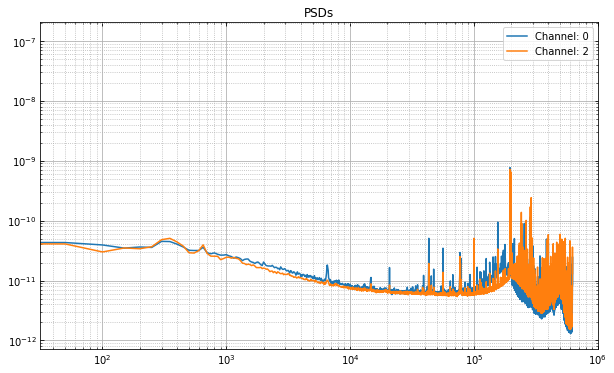

In [5]:
# create template with specific risetime and falltime 
#  rise_time/fall_time [in millisec] can be either single value (float) if same for each trigger channels
#  or an array with length = number of trigger channels
# 
# Filter file needs to contains a dictionary with:
#  'trigger_channels': string or list of string (should match trigger_channels from ContinuousData)
#  'psd' and 'template': array or list of array if multiple trigger channels
#  (optional) f,f_fold, psd_fold
rise_time = 20
fall_time = 30
data_inst.create_template(rise_time=rise_time,
                          fall_time=fall_time)

# calculate PSD
# PSD/template file can be saved (pickle file saved in trigger data directory, name automatically created)
# a subset of random events can be used (nb_events)
data_inst.calc_psd(nb_events=-1,
                   save_filter=True)

# check PSD / template 
filter_data = data_inst.get_psd_data()
print('\nFilter file data:')
pprint(filter_data)

# plot
fig, ax = plt.subplots(figsize=(10, 6))

# channels
channels = filter_data['trigger_channels']
if not isinstance(channels, list):
    channels = [channels]
for ichan in range(0, len(channels)):
    chan_name = channels[ichan]
    ax.loglog(filter_data['f_fold'][ichan], filter_data['psd_fold'][ichan]**0.5, 
            label=f'Channel: {chan_name}')
       
ax.legend()
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.grid(which="minor", linestyle="dotted")
ax.grid(which="major")
ax.set_title("PSDs")

## Acquire threshold trigger

In [6]:
# number of trigger events (-1 for all available triggers)
nb_events = 500
# threshold [sigma]: either float if same all trigger channels or a list with same length as number channels
threshold = 10
# window size to merge events (pile-up) in usec (if None: 1/2 tracelength)
pileup_window = None
# coincident window in usec ( for merging coincident events on channels from chan_to_trigger)
coincident_window = 50
# (optional) noise_psd     
# number of cores (for parallel processing)    
nb_cores = 4
    
data_inst.acquire_trigger(nb_events=nb_events,
                          threshold=threshold,
                          pileup_window=pileup_window,
                          coincident_window=coincident_window,
                          nb_cores=nb_cores)
                        


INFO: Starting trigger processing!
INFO: Total number of files to be processed = 5
INFO: Processing with be split on 4 cores!
INFO: Opening file name "/sdata1/runs/run17/raw/testproc_I2_D20220630_T131507/threshtrig_I2_D20220630_T131611_F0001.hdf5"
INFO: Opening file name "/sdata1/runs/run17/raw/testproc_I2_D20220630_T131507/threshtrig_I2_D20220630_T131613_F0001.hdf5"
INFO: Opening file name "/sdata1/runs/run17/raw/testproc_I2_D20220630_T131507/threshtrig_I2_D20220630_T131610_F0001.hdf5"
INFO: Opening file name "/sdata1/runs/run17/raw/testproc_I2_D20220630_T131507/threshtrig_I2_D20220630_T131612_F0001.hdf5"
INFO: Number of triggers = 50
INFO: Number of triggers = 50
INFO: Number of triggers = 50
INFO: Number of triggers = 50
INFO: Number of triggers = 100
INFO: Number of triggers = 100
INFO: Number of triggers = 100
INFO: Number of triggers = 100
INFO: Processing done!
